In [1]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import chess
import chess.pgn
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Mounted at /content/drive


#*Constants*

In [2]:
SQUARES = [
            'A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1',
            'A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2',
            'A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3',
            'A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4',
            'A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5',
            'A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6', 'H6',
            'A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7', 'H7',
            'A8', 'B8', 'C8', 'D8', 'E8', 'F8', 'G8', 'H8',
        ]

KEYS = ['b', 'k', 'n', 'p', 'q', 'r', 'from']

PIECE_TO_INDEX = {'P' : 0, 'N' : 1, 'B' : 2, 'R' : 3, 'Q' : 4, 'K' : 5,
                    'p': 6, 'n':7, 'b': 8, 'r': 9, 'q': 10, 'k':11
                    }

SEQUENCE_LENGTH = 20
IMAGE_HEIGHT = 8
IMAGE_WIDTH = 8

# Helper Functions

In [3]:
## Helper function

def parse_pgn(files):
  dict_games = []
  i = 0

  for elem in files:
    games = []
    while True:
      i += 1
      game = chess.pgn.read_game(elem)
      if game is None:
          break
      dict_games.append(list(game.main_line()))

    #dict_games.append(games)

  return dict_games


# def parse_pgn(files):
#   dict_games = []
#   i = 0

#   for elem in files:
#     games = []
#     while True:
#       i += 1
#       game = chess.pgn.read_game(elem)
#       if game is None:
#           break
#       dict_games=  dict_games + (list(game.main_line()))

#     #dict_games.append(games)

#   return dict_games

def read_pgn():
  filenames = os.listdir("/content/drive/MyDrive/ChessData")
  files = []
  for filename in filenames:
    pgn_file = open("/content/drive/MyDrive/ChessData/"+filename)
    files.append(pgn_file)

  return files


def convert_board(board): #type(board) == chess.Board()
    pgn = board.epd()
    foo = []  #Final board
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  #This is the row I make
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)

    temp7 = foo[7]
    temp6 = foo[6]

    # rotate board  
    foo[7] = foo[0]
    foo[6] = foo[1]

    foo[0] = temp7
    foo[1]= temp6

    return np.array(foo)


def piece_hot_vector(piece):
  # capital letters are the White pieces 
  # lowercase letters are the Black pieces

  array = np.zeros(12, dtype = int)

  if piece in PIECE_TO_INDEX.keys():
    array[PIECE_TO_INDEX[piece]] = 1

  return array

def create_board_matrix(matrix_board):
  array = []
  for row in range(8):
    row_list = []
    for column in range(8):
      row_list.append(0)

    array.append(row_list)

  for i in range(len(matrix_board)):
    for j, elem in enumerate(matrix_board[i]):
      array[i][j] = piece_hot_vector(elem)
      
  return np.array(array)



def create_piece_matrix(matrix_board, pieces):
  array = []
  for row in range(8):
    row_list = []
    for column in range(8):
      row_list.append(0)

    array.append(row_list)

  for i in range(len(matrix_board)):
    for j, elem in enumerate(matrix_board[i]):
      if elem in pieces:
        array[i][j] = piece_hot_vector(elem)
      else:
        array[i][j] = piece_hot_vector(" ")

      
  return np.array(array)



def get_available_pieces(chess_board):
  values = list(np.unique(chess_board))
  values.remove('.')
  return values


# def convert_position(position):
#   POS = {'a':0, 'b':1, 'c':2, 'd': 3, 'e':4, 'f':5, 'g': 6, 'h':7}
#   return str(int(position[1]) -1) + str(POS[position[0]])

def create_target_matrix(position):
  array = np.zeros(64, dtype=int)
  array[position] = 1

  return array


def convert_to_datasets(x,y,z):
  ds_train = tf.data.Dataset.from_tensor_slices( x )
  ds_valid = tf.data.Dataset.from_tensor_slices(y)
  ds_test = tf.data.Dataset.from_tensor_slices(z)
  ds_train = ds_train.map(preprocess).map(data_aug).batch(64).prefetch(1)
  ds_valid = ds_valid.map(preprocess).batch(64).prefetch(1)
  ds_test = ds_test.map(preprocess).batch(64).prefetch(1)
  
  return ds_train, ds_valid, ds_test


In [4]:
def create_dataset(list_of_games, full_train = True, keys=['from']):
  X = {}
  y = {}

  if not full_train:
    keys = KEYS

  for elem in keys:
    # list to hold all games
    X[elem] = []
    y[elem] = []


  for index, game in enumerate(list_of_games):
    # add a new list for games
    # for elem in keys:
    #   X[elem].append([])
    #   y[elem].append([])
    if len(X['from']) == 700000:
      break

    board = chess.Board()
    
    # foreach move in the current game
    for number, move in enumerate(game):
      #create x feature
      chess_matrix = convert_board(board)
      if full_train:
        X['from'].append(create_board_matrix(chess_matrix))
      else:
        piece = board.piece_at(move.from_square)
        piece_symbol = piece.symbol()
        X[piece_symbol.lower()].append(create_piece_matrix(chess_matrix, piece_symbol))  # piece will be moved

      #create y feature
      if full_train:
        y['from'].append(create_target_matrix(move.to_square))
      else:
        y[piece_symbol.lower()].append(create_target_matrix(move.to_square)) # position moved to

      #add next move
      board.push(move)

  # transform list to ndarray
  for elem in keys:
    X[elem] = np.array(X[elem])
    y[elem] = np.array(y[elem])
    
  return X, y



def create_crnn_dataset(list_of_games, full_train = True, keys=['from']):
  X = {}
  y = {}

  if not full_train:
    keys = KEYS

  for elem in keys:
    # list to hold all games
    X[elem] = []
    y[elem] = []


  for index, game in enumerate(list_of_games):
    # add a new list for games
    for elem in keys:
      X[elem].append([])
      y[elem].append([])

    board = chess.Board()
    
    # foreach move in the current game
    for number, move in enumerate(game):
      #create x feature
      chess_matrix = convert_board(board)
      if full_train:
        X['from'][index].append(create_board_matrix(chess_matrix))
      else:
        piece = board.piece_at(move.from_square)
        piece_symbol = piece.symbol()
        X[piece_symbol.lower()][index].append(create_piece_matrix(chess_matrix, piece_symbol))  # piece will be moved

      #create y feature
      if full_train:
        y['from'][index].append(create_target_matrix(move.to_square))
      else:
        y[piece_symbol.lower()][index].append(create_target_matrix(move.to_square)) # position moved to

      #add next move
      board.push(move)

  # transform list to ndarray
  # for elem in KEYS:
  #   X[elem] = np.array(X[elem])
  #   y[elem] = np.array(y[elem])
    
  return X, y


In [5]:

def remove_moves(features, targets, max_size=20,piece_train= False, keys=['from']):
  if piece_train:
    keys = KEYS
  
  for elem in keys:
    X = features[elem]
    y = targets[elem]


    for i, game in enumerate(X):
      game_size = len(game)
      new_game = []
      target_game = []

      if game_size > max_size:
        chosen_indicies = np.sort(np.random.choice(np.arange(0, game_size),
                                                   replace=False, size=max_size))
        for index in chosen_indicies:
          #print(X[i][index].shape)
          new_game.append(X[i][index])
          target_game.append(y[i][index])

        X[i] = np.array(new_game)
        y[i] = np.array(target_game)

      elif game_size < max_size:
        new_game = game
        target_game = y[i]
        while len(new_game) < max_size:
          new_game.append(np.zeros((8,8,12), dtype=int))
          target_game.append(np.zeros(64, dtype=int))

        X[i] = np.array(new_game)
        y[i] = np.array(target_game) 

    features[elem] = np.array(X)
    targets[elem] = np.array(y)


  return features, targets

#STUFF

In [6]:
filenames = os.listdir("/content/drive/MyDrive/ChessData")
files = []
for filename in filenames:
   pgn_file = open("/content/drive/MyDrive/ChessData/"+filename)
   files.append(pgn_file)

In [ ]:
files = read_pgn()

In [ ]:
game_list = parse_pgn(files)

In [ ]:
list_of_moves = []
for games in game_list:
  for move in games:
    list_of_moves.append(move)

In [ ]:
dict_x, dict_y = create_dataset(game_list)

In [ ]:
xx, dy = remove_moves(dict_x, dict_y)

In [ ]:
np.array(dict_x['p']).shape

(4314, 0)

In [ ]:
dict_x['from'].shape

(1580308, 8, 8, 12)

In [ ]:
dict_y['from'].shape

(1317582, 64)

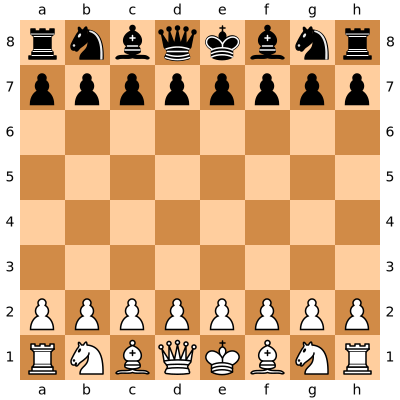

In [ ]:
board

#Models

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed( Conv2D(32, kernel_size =(3, 3), padding='same', activation="relu"),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 12)))
    
    # model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    # model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))
    # model.add(TimeDistributed(Dropout(0.25)))
    
    # model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))
    # #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32, return_sequences=True))
                                  
    model.add(TimeDistributed(Dense(64, activation = 'softmax')))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
def create_CNN_model():

  model = keras.models.Sequential([
        keras.layers.Conv2D(filters=128, kernel_size=[2,2], strides=[1,1],
                            padding="same", activation="relu", input_shape=(8,8,12)),
        keras.layers.Conv2D(filters=128, kernel_size=[2,2], strides=1, padding="same",
                            activation="relu"),
        # keras.layers.Conv2D(filters=128, kernel_size=[2,2], strides=1, padding="same",
        #                     activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dense(64, activation="softmax")
])
  
  return model


In [ ]:
keras.utils.plot_model(model1, show_shapes=True)

In [ ]:
model = create_CNN_model()

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'RMSprop', metrics = ["accuracy"])

In [ ]:
# create test set
X_train_tr, X_test, y_train_tr, y_test = train_test_split(dict_x['from'],
                                                                dict_y['from'],
                                                                test_size=0.3)

In [ ]:
# create validation set
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(dict_x['from'],
                                                                dict_y['from'],
                                                                test_size=0.2)

In [ ]:
history = model.fit(X_train_tr, y_train_tr, epochs=100, batch_size=32,
                    validation_data=(X_train_v, y_train_v),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])